In [33]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from array2gif import write_gif


class MNIST_Video(Dataset):
    def __init__(self, root='/scratch1/datasets/mnist', train=True, size=500, nframes=48,
                 windowsize=6, noise=0.1):
        mnist_dset = datasets.MNIST(root=root, train=train, download=False, transform=transforms.ToTensor())
        self.sample = np.random.choice(len(mnist_dset),size,replace=False)
        self.dset = torch.stack([mnist_dset[i][0] for i in self.sample])
        
        # The points that decide the class of each video
        self.choicePoints = np.random.choice(nframes, size, replace=True)
        self.classes = np.random.choice(2,size,replace=True)
        self.nframes = nframes
        self.windowsize=windowsize
        self.netframes = nframes-windowsize+1
        self.noise=noise
        #self.background = torch.zeros(1,128,128)
        
        self.startx = 50
        self.inc=2
        #self.starty = 0
        
    def __len__(self):
        return len(self.dset)*self.netframes
        
    def __getitem__(self, index):
        digitIndex = index//self.netframes
        frameIndex = index%self.netframes
        
        digit = self.dset[digitIndex]
        choicePoint = self.choicePoints[digitIndex]
        #choicePoint=24
        endPoint = frameIndex+self.windowsize
        
        yval = self.classes[digitIndex]
        if yval == 1:
            multiplier=-1 #Go upwards with value 1
        else:
            multiplier=1
        
        outx = self.startx+self.inc*multiplier*np.maximum(
            np.arange(frameIndex-choicePoint, frameIndex-choicePoint+self.windowsize),0)
        outx = np.minimum(np.maximum(outx,0),100)
        outy = self.inc*np.arange(frameIndex,endPoint)
        
        #import pdb; pdb.set_trace() #Debugging?
        pts = torch.zeros(self.windowsize,128,128)
        for i in range(self.windowsize):
            pts[i,outx[i]:outx[i]+28,outy[i]:outy[i]+28] = digit[0,:,:]
        pts = pts + self.noise*torch.randn(pts.size())
        pts = (pts-pts.min())/(pts.max()-pts.min())
            
        return pts, yval
       
    def changeWindowSize(self,newSize):
        self.windowsize = newSize
        self.netframes = self.nframes-newSize+1
    
    def write_gif(self, index, fname):
        backupWindowSize = self.windowsize
        self.changeWindowSize(48)
        pts, _ = self.__getitem__(index)
        pts = pts.unsqueeze(1)
        pts = torch.cat([pts,pts,pts],1)
        pts = pts.numpy()
        write_gif(pts*255, fname, fps=24)
        self.changeWindowSize(backupWindowSize)
        

# Inspired by Alexnet
class MNIST_Net(nn.Module):
    def __init__(self, windowsize, numclasses):
        super(MNIST_Net, self).__init__()
        self.main = nn.Sequential(
            # N x 128 x 128
            nn.Conv2d(windowsize, 64, kernel_size=7, stride=2, padding=3),
            # 64 x 64 x 64
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=, stride=),
            nn.Conv2d(64, 192, kernel_size=5, stride=2, padding=2),
            # 128 x 32 x 32
            nn.ReLU(inplace=True),
            nn.Conv2d(192,384, kernel_size=3, stride=2, padding=1),
            #256 x 16 x 16
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=0),
            # 256 x 14 x 14
            nn.ReLU(inplace=True),
        #    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),
            # 256 x 12 x 12
        #    nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
            # 256 x 6 x 6
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,numclasses)
        )
        
    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x).squeeze(1)
        return x
    
class Simple_MNIST_Net(nn.Module):
    def __init__(self, windowsize, numclasses):
        super(Simple_MNIST_Net, self).__init__()
        self.main = nn.Sequential(
            # N x 128 x 128
            nn.Conv2d(windowsize, 64, kernel_size=7, stride=2, padding=3),
            # 64 x 64 x 64
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=, stride=),
            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2),
            # 64 x 32 x 32
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64, kernel_size=3, stride=2, padding=1),
            #64 x 16 x 16
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*16*16, numclasses)
        )
        
    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x).squeeze(1)
        return x

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        init.normal(m.weight, std=1e-2)
        # init.orthogonal(m.weight)
        #init.xavier_uniform(m.weight, gain=1.4)
        if m.bias is not None:
            init.constant(m.bias, 0.0)

class AverageMeter(object):
    def __init__(self):
        self.count = 0
        self.value = 0
    def update(self, value, count=1):
        self.value += value
        self.count += count
    def average(self):
        return self.value / self.count
    def reset(self):
        self.count = 0
        self.value = 0
            
def train(nepochs, outname='model.pth', noise=0):
    device='cuda:0'
    dset = MNIST_Video(noise=noise)
    loader = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True, num_workers=4)
    
    #model = MNIST_Net(6,1)
    model = Simple_MNIST_Net(6,1)
    model.apply(weights_init)
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5,0.999))
    lossfunc = nn.BCEWithLogitsLoss()
    
    accuracyMeter = AverageMeter()
    lossMeter = AverageMeter()
    model.train()
    for epoch in range(nepochs):
        print("Epoch", epoch)
        accuracyMeter.reset()
        lossMeter.reset()
        for i, data in enumerate(loader):
            # Extract training batches
            ims, labels = data
            device_labels = labels.float().to(device)
            device_ims = ims.to(device)

            # Train network
            model.zero_grad()
            predictions = model(device_ims)
            loss = lossfunc(predictions, device_labels)
            loss.backward()
            optimizer.step()

            # Compute statistics
            rounded = torch.sigmoid(predictions).round().long()
            rounded = rounded.to('cpu')
            correct = torch.sum(rounded == labels).item()
            batch_size = predictions.size(0)
            accuracyMeter.update(correct, batch_size)
            lossMeter.update(loss.item())

            if i%100 == 0:
               # print("labels", labels)
               # print("predictions", rounded)
                accuracy = correct/batch_size
                print("batch {1}, batch_loss={2}, batch_accuracy={3}".format(
                    epoch,i,loss.item(),accuracy))
    
    torch.save(model.state_dict(), outname)

In [62]:
data = MNIST_Video()
x,y =data[0]
print(x.size(), y)
print(len(data))
# data.write_gif(0,'test0.gif')
# data.write_gif(1,'test1.gif')
# data.write_gif(2,'test2.gif')
# data.write_gif(3,'test3.gif')
# data.write_gif(499,'test499.gif')

torch.Size([6, 128, 128]) 1
21500


In [34]:
#train(10, 'model_6w_10e_0n.pth')
train(10, 'simple_model_6w_10e_0n.pth', noise=0.1)

Epoch 0


/scratch0/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:155: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/scratch0/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:159: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


batch 0, batch_loss=0.6943107843399048, batch_accuracy=0.4375
batch 100, batch_loss=0.6692947149276733, batch_accuracy=0.625
batch 200, batch_loss=0.3312029242515564, batch_accuracy=0.875
batch 300, batch_loss=0.37576135993003845, batch_accuracy=0.75
batch 400, batch_loss=0.3900432586669922, batch_accuracy=0.65625
batch 500, batch_loss=0.32730382680892944, batch_accuracy=0.84375
batch 600, batch_loss=0.40228211879730225, batch_accuracy=0.71875
Epoch 1
batch 0, batch_loss=0.382995069026947, batch_accuracy=0.75
batch 100, batch_loss=0.31886589527130127, batch_accuracy=0.75
batch 200, batch_loss=0.33740293979644775, batch_accuracy=0.8125
batch 300, batch_loss=0.26758044958114624, batch_accuracy=0.84375
batch 400, batch_loss=0.4052567183971405, batch_accuracy=0.71875
batch 500, batch_loss=0.3269391655921936, batch_accuracy=0.75
batch 600, batch_loss=0.2812035083770752, batch_accuracy=0.84375
Epoch 2
batch 0, batch_loss=0.4373282194137573, batch_accuracy=0.71875
batch 100, batch_loss=0.3485

In [28]:
import matplotlib.pyplot as plt
testmodel = Simple_MNIST_Net(6,1)
testmodel.load_state_dict(torch.load('simple_model_6w_10e_0n.pth'))
testmodel.eval()
testdata = MNIST_Video(train=False, noise=0.1)
testdata.write_gif(0,'testgif1.gif')
testdata.write_gif(1,'testgif2.gif')

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


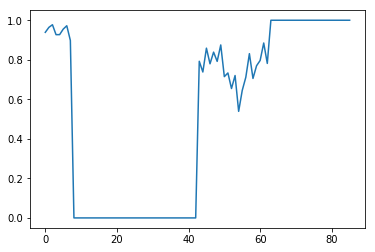

In [31]:
preds = []
allpts = []
for i in range(86):
    pt, y = testdata[i]
    print(y)
    allpts.append(pt)
    preds.append(torch.sigmoid(testmodel(pt.unsqueeze(0))).item())
plt.plot(preds)

In [86]:
print(preds)

[-0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.0710417777299881, -0.071041777

In [93]:
print(testmodel(torch.randn(1,6,128,128)).item())

16.603023529052734


In [94]:
pt, _ = testdata[20]
print(pt)

tensor([[[0.3070, 0.3208, 0.2880,  ..., 0.2586, 0.2576, 0.2112],
         [0.2403, 0.2422, 0.2529,  ..., 0.3340, 0.1981, 0.3173],
         [0.2670, 0.2955, 0.2368,  ..., 0.1742, 0.2502, 0.1891],
         ...,
         [0.2313, 0.3396, 0.2102,  ..., 0.3373, 0.3221, 0.3142],
         [0.3020, 0.3100, 0.2506,  ..., 0.2148, 0.2528, 0.2789],
         [0.3004, 0.3027, 0.2945,  ..., 0.2582, 0.1730, 0.2092]],

        [[0.3820, 0.2245, 0.3134,  ..., 0.2771, 0.2507, 0.4294],
         [0.2603, 0.3264, 0.2909,  ..., 0.3558, 0.1570, 0.2822],
         [0.2638, 0.3129, 0.1855,  ..., 0.3534, 0.2711, 0.3188],
         ...,
         [0.2978, 0.2240, 0.3443,  ..., 0.2672, 0.2335, 0.2886],
         [0.2195, 0.2122, 0.2089,  ..., 0.2566, 0.2508, 0.3518],
         [0.2598, 0.2758, 0.1932,  ..., 0.2854, 0.2830, 0.2117]],

        [[0.3398, 0.2599, 0.2605,  ..., 0.3129, 0.1497, 0.3473],
         [0.2609, 0.3250, 0.3552,  ..., 0.3051, 0.2842, 0.2480],
         [0.2358, 0.2455, 0.2295,  ..., 0.2217, 0.0880, 0.

In [101]:
allpts[0][1,:,:] == allpts[1][0,:,:]

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8)

12